# Disaster Classification

# Manav Jaiswal
# Souhardya Datta

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import shutil
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing

In [2]:
def main():

    count = 0
    
    for root, dirs, files in os.walk("D:/VIT/5th SEM/CSE4019/Project/Disaster_Dataset", topdown=False):
        for name in files:
                try:
                    img = Image.open(os.path.join(root, name))
                    img.verify()
                except (IOError, SyntaxError) as e:
                    
                    # Count number of corrupt images
                    count = count + 1
                    print('Bad file:', name)
                    
                    # Move corrupt images to a different folder on computer
                    #shutil.move(os.path.join(root, name), 'D:/VIT/5th SEM/CSE4019/Project/corrupt')
    print(f'Number of corrupted images found = {count}')

if __name__ == '__main__':
    main()

Number of corrupted images found = 0


### Transformations

In [3]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

## Disastermodel()

### Prepare Test and Train Sets, Loaders

splitfolders.ratio('../Data/Disaster_Dataset', output='../Data/Disasters', seed=1337, 
                               ratio=(.8, .2), group_prefix=None) 

import splitfolders
splitfolders.ratio('D:/VIT/5th SEM/CSE4019/Project/Disaster_Dataset', output='D:/VIT/5th SEM/CSE4019/Project/Data/Disasters', seed=1337, ratio=(.8, .2), group_prefix=None)

In [4]:
root = 'D:/VIT/5th SEM/CSE4019/Project/Data/Disasters'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'val'), transform = test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Drought', 'Earthquake', 'Human_Damage', 'Infrastructure', 'Land_Slide', 'Non_Damage_Buildings_Street', 'Non_Damage_Wildlife_Forest', 'Urban_Fire', 'Water_Disaster', 'Wild_Fire', 'human', 'sea']
Training images available: 10834
Testing images available:  2714


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [10]:
use_cuda

True

### Define Model

In [6]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.fc1 = nn.Linear(54*54*12, 48)
        self.fc2 = nn.Linear(48, 24)
        self.fc3 = nn.Linear(24, 12)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*12)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [7]:
torch.manual_seed(101)
DisasterModel = ConvolutionalNetwork()
DisasterModel.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=34992, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=12, bias=True)
)

### Define Loss and Optimization Functions

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(DisasterModel.parameters(), lr=0.001)

### Train Model

In [9]:
import time
start_time = time.time()

epochs = 20

# Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        y_pred = DisasterModel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tracking correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print epoch and loss results
        if b%100==0:
            print(f'EPOCH: {i}  LOSS: {loss.item():10.8f}')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            y_val = DisasterModel(X_test)

            # Tracking correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {(time.time() - start_time)/60} minutes')

EPOCH: 0  LOSS: 1.59404826
EPOCH: 1  LOSS: 1.24864268
EPOCH: 2  LOSS: 1.02186406
EPOCH: 3  LOSS: 1.04771984
EPOCH: 4  LOSS: 1.00388062
EPOCH: 5  LOSS: 0.74705756
EPOCH: 6  LOSS: 0.82798064
EPOCH: 7  LOSS: 0.66204590
EPOCH: 8  LOSS: 0.47108760
EPOCH: 9  LOSS: 0.45658061
EPOCH: 10  LOSS: 0.50887066
EPOCH: 11  LOSS: 0.27159068
EPOCH: 12  LOSS: 0.54561436
EPOCH: 13  LOSS: 0.45605493
EPOCH: 14  LOSS: 0.61639780
EPOCH: 15  LOSS: 0.43443215
EPOCH: 16  LOSS: 0.64382869
EPOCH: 17  LOSS: 0.28061903
EPOCH: 18  LOSS: 0.67545241
EPOCH: 19  LOSS: 0.44038191

Duration: 71.47224881649018 minutes


In [11]:
torch.save(DisasterModel.state_dict(), 'DisasterModel.pt')

### Model Performance

In [57]:
tr_loss=[]
te_loss=[]
tr_acc=[]
te_acc=[]

In [58]:
for i in range(20):
    j=train_losses[i].cpu().data.numpy()
    tr_loss.append(j)
    j=test_losses[i].cpu().data.numpy()
    te_loss.append(j)
    j=train_correct[i].cpu().data.numpy()
    tr_acc.append(j)
    j=test_correct[i].cpu().data.numpy()
    te_acc.append(j)

In [55]:
train_losses

[tensor(0.9771, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.3998, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.0718, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.6085, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.9297, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.1418, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.9186, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.5456, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.4423, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.5958, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.5982, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.3497, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.5941, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.4584, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.3810, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.7896, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

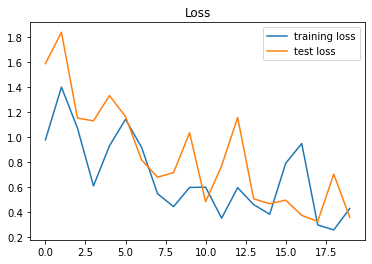

In [59]:
plt.plot(tr_loss, label='training loss')
plt.plot(te_loss, label='test loss')
plt.title('Loss')
plt.legend();

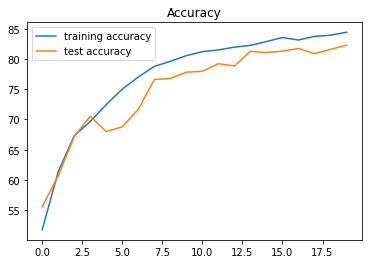

In [54]:
plt.plot([t/108 for t in tr_acc], label='training accuracy')
plt.plot([t/27 for t in te_acc], label='test accuracy')
plt.title('Accuracy')
plt.legend();

In [60]:
print(f' Test accuracy = {(test_correct[-1].item()/2714)*100} %')

 Test accuracy = 81.8349299926308 %


### Predicting New Image

In [61]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])

In [63]:
use_cuda = False
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [65]:
DisasterModel.to(device)
DisasterModel.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=34992, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=12, bias=True)
)

Predicted value: 0 Drought


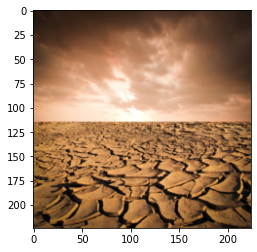

In [98]:
im = inv_normalize(test_data[12][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

with torch.no_grad():
    new_pred = DisasterModel(test_data[12][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')